In [25]:
import cv2
import argparse
import imutils
import time
import scipy.io
# from sklearn.svm import SVC
import skvideo.io
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.ndimage import morphology as mp
from skimage.feature import canny
from thundersvm import SVC
from random import sample
import matplotlib.patches as patches
from PIL import Image
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import image
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from imutils.video import VideoStream
from imutils.video import FPS
import os
import pickle
import copy

In [26]:
def rgbNormalize(im):
    [m,n,p] = im.shape
    r = im[:,:,0]
    r1 = r.flatten()
    g = im[:,:,1]
    g1 = g.flatten()
    b = im[:,:,2]
    b1 = b.flatten()
    N = len(r1)
    rmed = np.median(r1)
    gmed = np.median(g1)
    bmed = np.median(b1)
    sigma = sum( abs(r1 - rmed) + abs(g1 - gmed) + abs(b1 - bmed) )/(3*N)
    r = (r - rmed)/sigma
    g = (g - gmed)/sigma
    b = (b - bmed)/sigma
    im[:,:,0] = r
    im[:,:,1] = g
    im[:,:,2] = b
    
    return im

In [27]:
def normalizeSV(im):
    s = im[:,:,1]
    s1 = s.flatten()
    v = im[:,:,2]
    v1 = v.flatten()
    smed = np.median(s1)
    vmed = np.median(v1)
    N = len(s1)
    sigma1 = sum( abs(s1 - smed) )/N
    sigma2 = sum( abs(v1 - vmed) )/N
    s = (s - smed)/sigma1
    v = (v - vmed)/sigma2
    im[:,:,1] = s
    im[:,:,2] = v
    
    return im

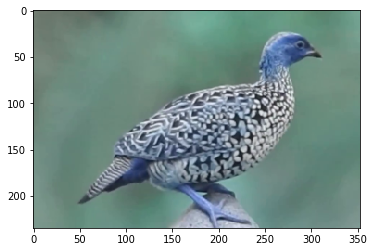

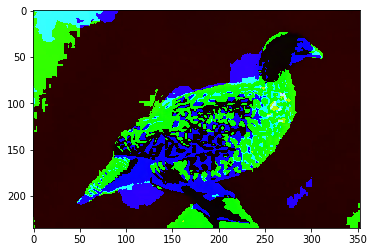

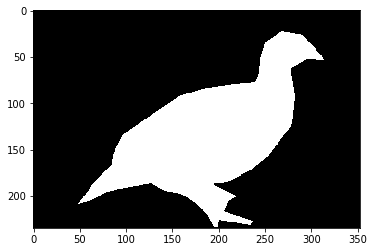

In [28]:
label=9
basepath = "training/"+str(label)+"/"
loadpath = basepath+"train/"
f1 = "C3wkLDsVUwM"
img = cv2.imread(loadpath+f1+'-frame.png');
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_HSV = normalizeSV(img_HSV)
# img2 = rgbNormalize(img)
# img=img[:,:,0]
sil = cv2.imread(loadpath+f1+'-gt.png');
# sil = cv2.cvtColor(sil, cv2.COLOR_BGR2RGB)
# sil=sil[:,:,0]
# [m,n] = img.shape
# [m1,n1] = sil.shape
# a=0
# b=0
# if(m1<m):
#     a = m 
plt.imshow(img),plt.show();
plt.imshow(img_HSV),plt.show();
plt.imshow(sil*255),plt.show();
# cv2.imshow("Img",img);
# cv2.imshow("Sil",sil);
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [33]:
[m,n,p] = img_HSV.shape
im = np.zeros([m,n,p-1])
im[:,:,0] = img_HSV[:,:,0]
im[:,:,1] = img_HSV[:,:,2]

In [34]:
im.shape

(235, 353, 2)

In [35]:
patches=[]
# GT=[]
psize=8
patches = image.extract_patches_2d(im, (psize, psize))
# GT = image.extract_patches_2d(sil, (psize, psize))

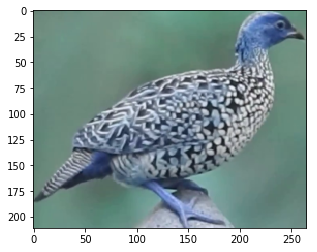

In [14]:
sil_gray = cv2.cvtColor(sil, cv2.COLOR_BGR2GRAY)
i, j = np.where(sil_gray)
indices = np.meshgrid(np.arange(min(i), max(i) + 1),
                      np.arange(min(j), max(j) + 1),
                      indexing='ij')
sub_image = img[indices]
plt.imshow(sub_image),plt.show();

In [15]:
indices

[array([[ 23,  23,  23, ...,  23,  23,  23],
        [ 24,  24,  24, ...,  24,  24,  24],
        [ 25,  25,  25, ...,  25,  25,  25],
        ...,
        [231, 231, 231, ..., 231, 231, 231],
        [232, 232, 232, ..., 232, 232, 232],
        [233, 233, 233, ..., 233, 233, 233]]),
 array([[ 49,  50,  51, ..., 311, 312, 313],
        [ 49,  50,  51, ..., 311, 312, 313],
        [ 49,  50,  51, ..., 311, 312, 313],
        ...,
        [ 49,  50,  51, ..., 311, 312, 313],
        [ 49,  50,  51, ..., 311, 312, 313],
        [ 49,  50,  51, ..., 311, 312, 313]])]

In [16]:
x1,y1 = indices[0][0,0],indices[1][0,0]

In [17]:
x1,y1

(23, 49)

In [18]:
x2,y2 = indices[0][indices[0].shape[0]-1,indices[0].shape[1]-1],indices[1][indices[1].shape[0]-1,indices[1].shape[1]-1]

In [19]:
x2,y2

(233, 313)

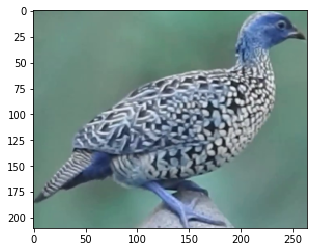

In [20]:
sub_image = []
sub_image = img[x1:x2,y1:y2]
plt.imshow(sub_image),plt.show();

In [21]:
# im = img[0:8,0:8]
patches=[]
GT=[]
psize=8
patches = image.extract_patches_2d(img, (psize, psize))
GT = image.extract_patches_2d(sil, (psize, psize))
X=[]
Y=[]
i=0;
print("Total Patches:"+str(len(patches)));
while i < len(patches):
# for i in range(len(patches)):
    a = patches[i].flatten()
    if(np.count_nonzero(GT[i])>=(psize*psize/2)*3):
        Y.append(1)
    else:
        Y.append(0)

    X.append(a)
    i=i+1


Total Patches:78888


In [23]:
svc = SVC(C=1,kernel='rbf',gamma=1/(X[0].shape[0]*np.array(X).var()))
svc.fit(X,Y)

SVC(C=1, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=6.189740517262803e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [69]:
def trainVideo2(file,boxes,label,filename):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
    disp_flag=False
    capture=True
    next_frame=[]
    corners=[]
    img=[]
    storepath = 'output/'+str(label)+"/"
    nos = 100
    if not os.path.exists(storepath):
        os.mkdir(storepath)
    fname = filename.strip('.mp4')
    writer = skvideo.io.FFmpegWriter(storepath+fname+"_"+str(nos)+".mp4")
    
    def mouse_click(event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            corners.append([x,y])
            for i in corners:
                [x,y] = i
                cv2.circle(cropped_im,(x,y),3,255,-1)

#     track_window = (0,0,0,0)
#     track = False

    cur_no=0
    count = 1
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if fno in boxes:
            (x1,y1,x2,y2) = boxes[fno]

            if x2<x1:
                temp=x2
                x2=x1
                x1=temp
            if y2<y1:
                temp=y2
                y2=y1
                y1=temp

            if x2>W:
                x2=W
            if y2>H:
                y2=H
            if x1<0:
                x1=0
            if y1<0:
                y1=0
            cropped_im = frame[y1:y2,x1:x2]

            print("Frame:"+str(fno));
#             plt.imshow(cropped_im),plt.show();
            if(capture):
                next_img = predictSilhouette2(cropped_im)
                [m,n,p] = next_img.shape
                diff = 400 - m
                top = int(diff/2)
                bot = diff -top
                diff = 500 - n
                left = int(diff/2)
                right = diff -left
                padded_img= cv2.copyMakeBorder(next_img,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
                padded_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)
                writer.writeFrame(padded_img)
#                 out.write(padded_img)
                cur_no = cur_no+1
                if(cur_no>=nos):
                    count=count+1
                    nos=100*count
                    writer.close()
                    writer = skvideo.io.FFmpegWriter(storepath+fname+"_"+str(nos)+".mp4")
#                     out.release()
#                     break
#                 cv2.imshow("Silhouette:"+str(fno), padded_img)
#             plt.clf()

        fno=fno+1

    vs.release()
    writer.close()
#     out.release()
    
    # close all windows
#     cv2.destroyAllWindows()
#     data={'X':X,'Y':Y}
    return frame_array

In [70]:
############################# Method for testing with Strides ###################################
def predictSilhouette2(next_img):
#     x1,y1,x2,y2 = box
    i=0;
    TEST1=None
#     psize=16
    # psize=4
#     [m,n,p] = next_img.shape
#     while i<(m-psize):
#         j=0;
#         while j<(n-psize):
#             a = copy.copy(next_img[i:i+psize,j:j+psize])
#             a = a.flatten()
#             if TEST1 is None:
#                 TEST1 = a
#             else:
#                 TEST1 = np.vstack([TEST1,a])
#             j=j+int(psize/2)
#         i=i+int(psize/2)

#     predictions = svc.predict(TEST1)

#     i=0;
#     k=0;
#     [m,n,p] = next_img.shape
#     new_mask = np.zeros([m,n,p])
#     count = np.zeros([m,n,p])
#     while i<(m-psize):
#         j=0;
#         while j<(n-psize):
#             if k < len(predictions):
#                 if(predictions[k]==1):
#                     new_mask[i:i+psize,j:j+psize] = new_mask[i:i+psize,j:j+psize] + 1
#                     count[i:i+psize,j:j+psize] = count[i:i+psize,j:j+psize] + 1
#                 k = k+1
#             j=j+int(psize/2)
#         i=i+int(psize/2)

#     count [count==0] = 1
#     reconstructed1 = []
#     reconstructed1 = new_mask/count
#     ret,thresh1 = cv2.threshold(reconstructed1,0.7,1,cv2.THRESH_BINARY)
#     print("Thresholded Mask:");
# #     plt.imshow(thresh1),plt.show();

# #     mask1 = reconstructed1.astype(np.bool)
#     mask1 = thresh1.astype(np.bool)
#     silhouette1 = np.zeros_like(next_img)
#     silhouette1[mask1] = next_img[mask1]
#     print("Thresholded Silhouette:");
# #     plt.imshow(silhouette1),plt.show();

#     gray_sil = cv2.cvtColor(silhouette1, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
    
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
# #     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
# #     cv2.rectangle(silhouette, (x1, y1), (x2, y2),
# #                         (0, 255, 0), 2)
# #     cv2.imshow("Frame:",silhouette);
# #     plt.imshow(silhouette),plt.show();
    
# #     edges = canny(connected_mask)
# #     fill_holes = mp.binary_fill_holes(edges)

# #     stacked_img = np.stack((fill_holes,)*3, axis=-1)
# #     stacked_img = stacked_img.astype(float)
# #     # type(stacked_img)
# # #     print("Filled Mask:");
# # #     plt.imshow(stacked_img),plt.show();

# #     mask2 = stacked_img.astype(np.bool)
# #     silhouette2 = np.zeros_like(next_img)
# #     silhouette2[mask2] = next_img[mask2]
# # #     print("Filled Silhouette:");
# #     plt.imshow(silhouette2),plt.show();
    
#     return silhouette

###############################################################################

    flt
    mask = np.zeros_like(next_patches)
    for i in range(len(predictions)):
        if(predictions[i]==1):
            mask[i] = mask[i] + 1
    
    ## Using thresholding on the image
    reconstructed = []
    reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
    plt.imshow(reconstructed),plt.show();

    mask2 = reconstructed.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask2] = next_img[mask2]
    
    gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
    connected_mask = undesired_objects(gray_sil)
    stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
    edges = canny(connected_mask)
    fill_holes = morph.binary_fill_holes(edges)
    stacked_img2 = np.stack((fill_holes,)*3, axis=-1)
    stacked_img = stacked_img + stacked_img2
    
    mask = stacked_img.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask] = next_img[mask]
    
    
    
    plt.imshow(silhouette),plt.show();
    
#     ## Using maximally connected components on the image
#     reconstructed = []
#     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
    
#     ret,thresh1 = cv2.threshold(reconstructed,0.6,1,cv2.THRESH_BINARY)
#     print("Thresholded Mask:");
#     plt.imshow(thresh1),plt.show();
    
# #     plt.imshow(reconstructed),plt.show();
#     mask2 = thresh1.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask2] = next_img[mask2]
    
#     gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
#     plt.imshow(silhouette),plt.show();
    return silhouette

In [71]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

#     img2 = np.zeros(output.shape)
#     img2[output == max_label] = 255
#     plt.imshow(img2),plt.show();
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    return img2
#     cv2.imshow("Biggest component", img2)
#     cv2.waitKey()

In [2]:
basePath = "../IndianBirds/"
frame_array=[]
for i in range(9,10):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    f = open(fullPath+"bbox.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     box = boxes[allfiles[0]][221]
    for file in allfiles:
#     for file in ["C3wkLDsVUwM.mp4"]:
        if file.endswith(".mp4"):
            print(file)
#             if(j==1):
#             frame_array = trainVideo2(fullPath+file,boxes[file],i,file)
            j=j+1
        if (j==1):
            break

C3wkLDsVUwM.mp4


In [ ]:
# ############################# MeanShift based searching ###################################
# def predictSilhouette2(next_img):
    
#     i=0;
#     TEST1=None
# #     psize=16
#     # psize=4
#     [m,n,p] = next_img.shape
#     while i<(m-psize):
#         j=0;
#         while j<(n-psize):
#             a = copy.copy(next_img[i:i+psize,j:j+psize])
#             a = a.flatten()
#             if TEST1 is None:
#                 TEST1 = a
#             else:
#                 TEST1 = np.vstack([TEST1,a])
#             j=j+int(psize/2)
#         i=i+int(psize/2)

#     predictions = svc.predict(TEST1)

#     i=0;
#     k=0;
#     [m,n,p] = next_img.shape
#     new_mask = np.zeros([m,n,p])
#     count = np.zeros([m,n,p])
#     while i<(m-psize):
#         j=0;
#         while j<(n-psize):
#             if k < len(predictions):
#                 if(predictions[k]==1):
#                     new_mask[i:i+psize,j:j+psize] = new_mask[i:i+psize,j:j+psize] + 1
#                     count[i:i+psize,j:j+psize] = count[i:i+psize,j:j+psize] + 1
#                 k = k+1
#             j=j+int(psize/2)
#         i=i+int(psize/2)

#     count [count==0] = 1
#     reconstructed1 = []
#     reconstructed1 = new_mask/count
#     ret,thresh1 = cv2.threshold(reconstructed1,0.7,1,cv2.THRESH_BINARY)
#     print("Thresholded Mask:");
#     plt.imshow(thresh1),plt.show();

# #     mask1 = reconstructed1.astype(np.bool)
#     mask1 = thresh1.astype(np.bool)
#     silhouette1 = np.zeros_like(next_img)
#     silhouette1[mask1] = next_img[mask1]
#     print("Thresholded Silhouette:");
# #     plt.imshow(silhouette1),plt.show();

#     gray_sil = cv2.cvtColor(silhouette1, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
    
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
# #     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
#     plt.imshow(silhouette),plt.show();
    
# #     edges = canny(connected_mask)
# #     fill_holes = mp.binary_fill_holes(edges)

# #     stacked_img = np.stack((fill_holes,)*3, axis=-1)
# #     stacked_img = stacked_img.astype(float)
# #     # type(stacked_img)
# # #     print("Filled Mask:");
# # #     plt.imshow(stacked_img),plt.show();

# #     mask2 = stacked_img.astype(np.bool)
# #     silhouette2 = np.zeros_like(next_img)
# #     silhouette2[mask2] = next_img[mask2]
# # #     print("Filled Silhouette:");
# #     plt.imshow(silhouette2),plt.show();
    
#     return silhouette

# ###############################################################################

# #     next_patches = image.extract_patches_2d(next_img, (8, 8))
# #     TEST=[]
# #     for i in range(len(next_patches)):
# #         a = next_patches[i].flatten()
# #         TEST.append(a)
# #     predictions = svc.predict(TEST)
# #     mask = np.zeros_like(next_patches)
# #     for i in range(len(predictions)):
# #         if(predictions[i]==1):
# #             mask[i] = mask[i] + 1
# # #     ## Using thresholding on the image
# # #     reconstructed = []
# # #     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
# # # #     plt.imshow(reconstructed),plt.show();
# # #     ret,thresh1 = cv2.threshold(reconstructed,0.5,1,cv2.THRESH_BINARY)
# # # #     plt.imshow(thresh1),plt.show();
    
# # #     mask2 = thresh1.astype(np.bool)
# # #     silhouette = np.zeros_like(next_img)
# # #     silhouette[mask2] = next_img[mask2]
    
# #     ## Using maximally connected components on the image
# #     reconstructed = []
# #     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
    
# #     ret,thresh1 = cv2.threshold(reconstructed,0.6,1,cv2.THRESH_BINARY)
# #     print("Thresholded Mask:");
# #     plt.imshow(thresh1),plt.show();
    
# # #     plt.imshow(reconstructed),plt.show();
# #     mask2 = thresh1.astype(np.bool)
# #     silhouette = np.zeros_like(next_img)
# #     silhouette[mask2] = next_img[mask2]
    
# #     gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
# #     connected_mask = undesired_objects(gray_sil)
# #     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
# #     plt.imshow(stacked_img),plt.show();
    
# #     mask = stacked_img.astype(np.bool)
# #     silhouette = np.zeros_like(next_img)
# #     silhouette[mask] = next_img[mask]
# #     plt.imshow(silhouette),plt.show();
# #     return silhouette